* **Author** : Poojashree NS



* **Team** : Data-Miners

**Introduction**

This colab covers the Customer Segmentation using Fractral clustering based on Recency, Frequency and Monetary Analysis.

**Background**

E-commerce is a business method that enables people or companies to buy and sell things through the internet. E-commerce buyers come in a wide range of personalities, and a potential market is rarely defined in a single way. It's critical to understand your target market in order to ensure that your communications are both effective (attractive, action-oriented) and suitable (non-offensive, timely, and relevant). RFM analysis is a technique for segmenting client behavior. RFM analysis concentrates on 3 primary features of clients' transactions: recency, frequency, and purchase quantity, all of which are based on historical transactions. Understanding these behaviors will allow businesses to cluster different customers into groups.

**Problem Statement**

* Group customers based on their behavior so that they are divided into several segments based on RFM Analytics.
* Find out the defining characteristics in each customer segment.

**Task**

* Clustering

**Dataset Understanding**

**Dataset 1 : Kaggle Brazilian Ecommerce Olist** The dataset contains information of 100k orders placed in numerous Brazilian markets between 2016 and 2018. This is real business information that has been anonymized. Olist, the largest department store in Brazil, has generously shared this data collection. Olist connects small businesses from all around Brazil to the channel in a simple and cost-effective manner. The merchant can sell their products on the Olist Store and have them transported straight to customers through the Olist logistics partner. The vendor will be alerted to complete the order once the buyer has purchased the product from the Olist Store.When the client receives the product or the estimated delivery date approaches, the customer receives an email with a satisfaction survey where he or she can leave a note and some remarks on the purchase experience.

**Dataset 2 : UCI E-commerce**

**Dataset 3 : Scrape Dataset - TBD**


In [1]:
#importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# import gc
# import itertools
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)

from sklearn.cluster import KMeans

## **Defining visualization functions**

In [2]:
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(True)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

In [3]:
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

## **Data Preparation**

In [4]:
# load the data
customer = pd.read_csv('/content/olist_customers_dataset.csv')
order = pd.read_csv('/content/olist_orders_dataset.csv')
item = pd.read_csv('/content/olist_order_items_dataset.csv')
payment = pd.read_csv('/content/olist_order_payments_dataset.csv')

In [5]:
# creating master dataframe 
df1 = payment.merge(item, on='order_id')
df2 = df1.merge(order, on='order_id')
df = df2.merge(customer, on='customer_id')
print(df.shape)

(117601, 22)


In [6]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [7]:
# cleaning up name columns
df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()

# engineering new/essential columns
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

# Changing the month attribute for correct ordenation
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)

#creating year month column
df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [8]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712
3,ba78997921bbcdc1373bb41e913ab953,1,Credit Card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,17.88,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,36060,Juiz De Fora,MG,13.0,2017,12,2,12,Wed,Dec,2017-12,201712
4,42fdf880ba16b47b59251dd489d4441a,1,Credit Card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,14.88,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13,4291db0da71914754618cd789aebcd56,18570,Conchas,SP,11.0,2018,5,0,13,Mon,May,2018-05,201805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,0406037ad97740d563a178ecc7a2075c,1,Boleto,1,363.31,1,1302fd16bdfe85e523940c846370ef2c,a369d693961cb93b61ca2cc518872a85,2018-03-15 03:55:25,297.00,66.31,5d576cb2dfa3bc05612c392a1ee9c654,delivered,2018-03-08 16:57:23,2018-03-10 03:55:25,2018-03-12 18:19:36,2018-03-16 13:09:51,2018-04-04,b6027ac07fb76ebca8c97b1887865aee,12954,Atibaia,SP,18.0,2018,3,3,16,Thu,Mar,2018-03,201803
117597,7b905861d7c825891d6347454ea7863f,1,Credit Card,2,96.80,1,fb55982be901439613a95940feefd9ee,3d871de0142ce09b7081e2b9d1733cb1,2017-08-24 10:04:56,79.00,17.80,2079230c765a88530822a34a4cec2aa0,delivered,2017-08-18 09:45:35,2017-08-18 10:04:56,2017-08-18 18:04:24,2017-08-23 22:25:56,2017-09-12,53b30ca78efb2b7efcd3f9e461587eb2,30210,Belo Horizonte,MG,19.0,2017,8,4,9,Fri,Aug,2017-08,201708
117598,32609bbb3dd69b3c066a6860554a77bf,1,Credit Card,1,47.77,1,848ef0a103ee21407d1fbd0f7e7ae179,3d621842b2ed28e2b474132480edac3c,2017-11-27 17:46:05,39.99,7.78,e4abb5057ec8cfda9759c0dc415a8188,invoiced,2017-11-18 17:27:14,2017-11-18 17:46:05,NaT,NaT,2017-12-05,d3c7da954a324253814096bcaf240e4e,1519,Sao Paulo,SP,NaN,2017,11,5,17,Sat,Nov,2017-11,201711
117599,b8b61059626efa996a60be9bb9320e10,1,Credit Card,5,369.54,1,e9c1abcc7126360336d8f56d49041a8c,679769a98cfcc6da877c8486ff1c13f3,2018-08-13 23:45:00,349.00,20.54,5d719b0d300663188169c6560e243f27,delivered,2018-08-07 23:26:13,2018-08-07 23:45:00,2018-08-09 11:46:00,2018

In [9]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,order_delivered_customer_date,delivery_against_estimated,order_delivered_carrier_date,order_approved_at,month_year,order_purchase_mon,order_purchase_day,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,order_purchase_year,customer_state,customer_city,customer_zip_code_prefix,customer_unique_id,order_estimated_delivery_date,order_id,payment_sequential,order_purchase_timestamp,order_status,customer_id,freight_value,price,shipping_limit_date,seller_id,product_id,order_item_id,payment_value,payment_installments,payment_type,month_y
Values,2567.000000,2567.000000,1245.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.182805,2.182805,1.058664,0.012755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [11]:
# excluding incomplete data
df = df.query("month_year != '2016-12' and month_year != '2016-10'")

## **Data Analysis**

*Calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns*

In [12]:
df_revenue = df.groupby(['month_year'])['payment_value'].sum().reset_index()
df_revenue

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


*Calculating for monthly revenue growth rate and using pct_change() function to see monthly percentage change*

In [13]:
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,month_year,payment_value,MonthlyGrowth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


*Creating monthly active customers dataframe by counting unique Customer IDs*

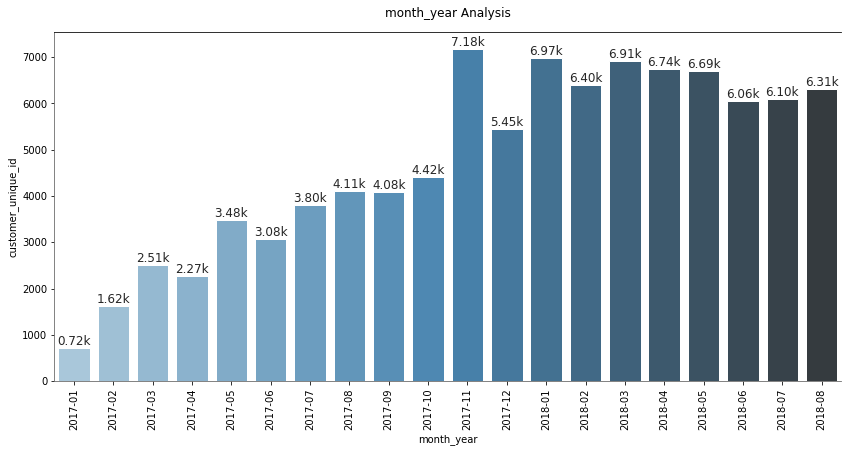

In [14]:
df_monthly_active = df.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

*creating monthly sales dataframe by counting order status*

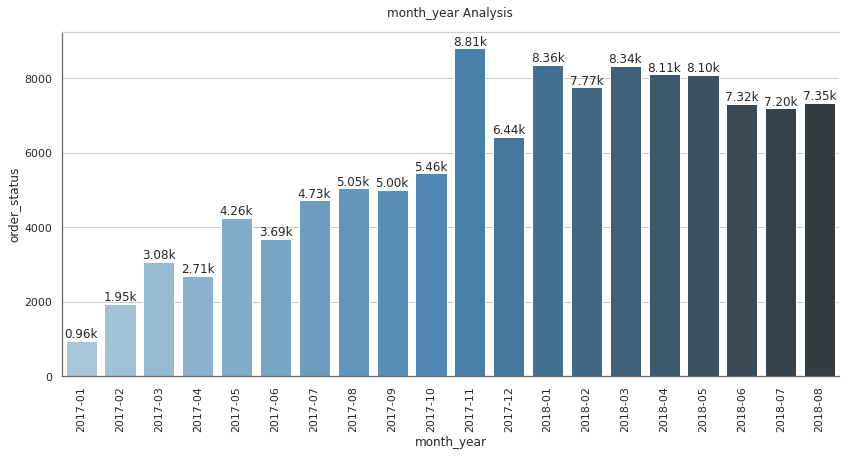

In [15]:
df_monthly_sales = df.groupby('month_year')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='bright', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='order_status', df=df_monthly_sales, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

*create a new dataframe for average revenue by taking the mean of it*

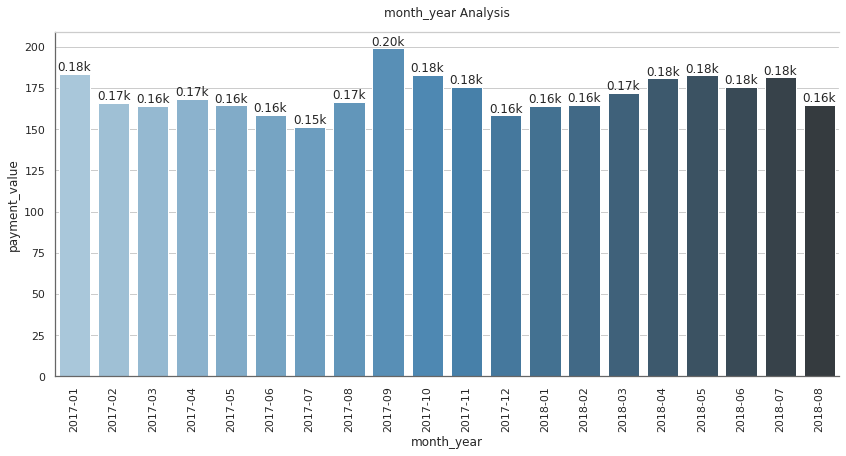

In [16]:
df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

*Create a dataframe contaning CustomerID and first purchase date and merge first purchase date column to our main dataframe.*

In [17]:

df_min_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()

df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

df = pd.merge(df, df_min_purchase, on='customer_unique_id')

*Create a column called User Type and assign New or Existing based on purchase date.*

*Calculate the Revenue per month for each user type.*

In [18]:
df['usertype'] = 'New'
df.loc[df['month_y']>df['minpurchasedate'],'usertype'] = 'Existing'

df_user_type_revenue = df.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue.head()

,month_y,usertype,month_year,payment_value
0,201701,New,2017-01,176376.56
1,201702,Existing,2017-02,111.07
2,201702,New,2017-02,323704.88
3,201703,Existing,2017-03,596.38
4,201703,New,2017-03,505139.45


*Plotting Exisiting Vs New customer over months*

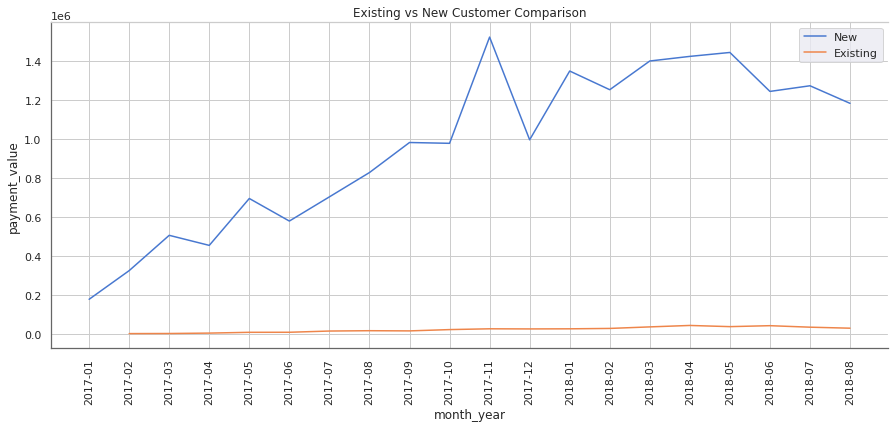

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

*Creating a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)*

*Dropping nan values that resulted from first and last month*




In [20]:
df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

df_user_ratio

,month_year,NewCusRatio
1,2017-02,808.000000
2,2017-03,500.600000
3,2017-04,132.764706
4,2017-05,123.214286
5,2017-06,77.871795
6,2017-07,76.591837
7,2017-08,71.175439
8,2017-09,51.333333
9,2017-10,49.193182
10,2017-11,57.868852


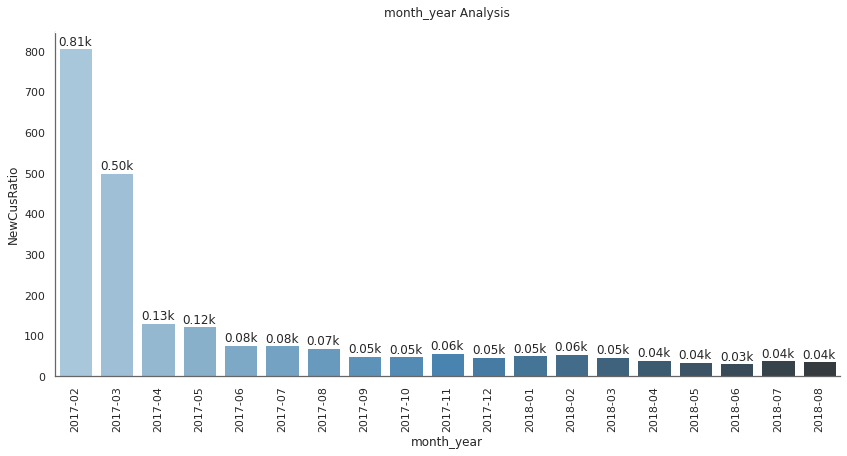

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

*Identifying active users who are active by looking at their revenue per month*

In [22]:
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


*Identifying active users who are active by looking at their order count per month*

In [23]:
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


*Creating retention matrix with crosstab using purchase*

In [24]:
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y,customer_unique_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


*Creating an array of dictionary which keeps Retained & Total User count for each month*

In [25]:
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201703,2508,3,0.001196
1,201704,2274,11,0.004837
2,201705,3478,14,0.004025
3,201706,3076,16,0.005202
4,201707,3802,16,0.004208
5,201708,4114,23,0.005591
6,201709,4082,32,0.007839
7,201710,4417,32,0.007245
8,201711,7182,37,0.005152
9,201712,5450,41,0.007523


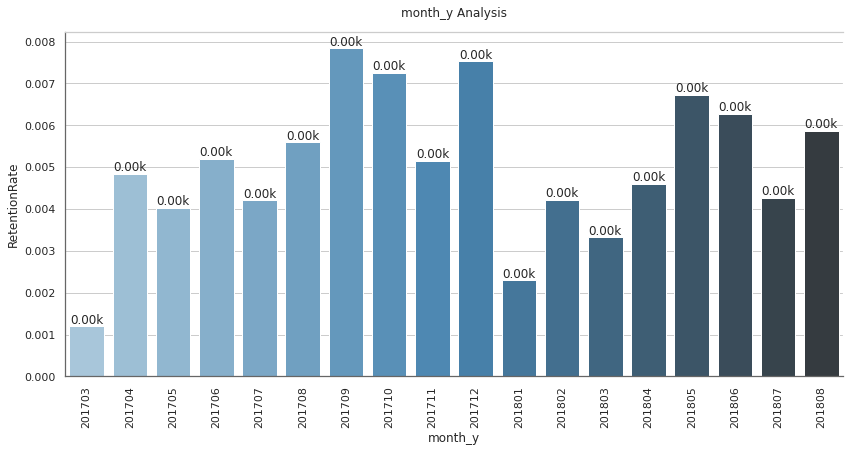

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_y', y='RetentionRate', df=df_retention, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## **Feature Extraction**

**Recency**

*Creating a generic user dataframe to keep CustomerID and new segmentation scores.*

*Get the max purchase date for each customer and create a dataframe with it.*

*Take our observation point as the max purchase date in our dataset.*



In [27]:
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,a8b9d3a27068454b1c98cc67d4e31e6f,64
2,6f70c0b2f7552832ba46eb57b1c5651e,260
3,87695ed086ebd36f20404c82d20fca87,266
4,4291db0da71914754618cd789aebcd56,28


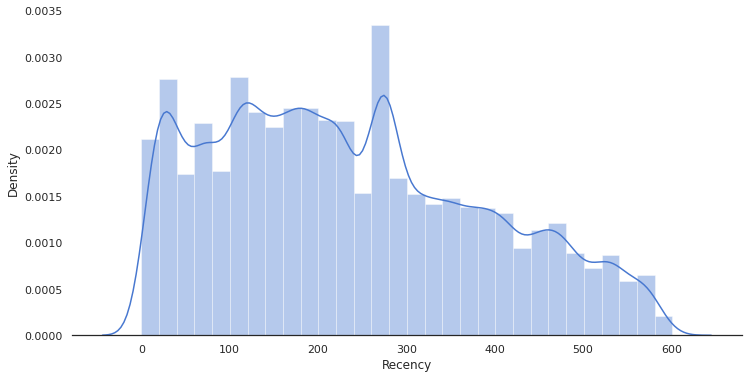

In [28]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

**Recency Cluster**

*Elbow Method*

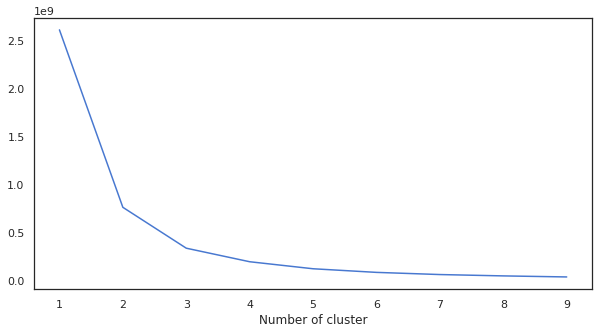

In [29]:
sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [30]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [31]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,14520.0,503.543595,42.605553,440.0,467.0,496.0,537.0,601.0
1,18398.0,375.236439,33.801377,319.0,346.0,375.0,404.0,439.0
2,27252.0,260.219874,31.029973,207.0,231.0,265.0,281.0,318.0
3,29976.0,152.353082,30.925276,101.0,125.0,153.0,180.0,206.0
4,24535.0,48.260322,27.790662,0.0,24.0,44.0,73.0,100.0


**Frequency**

Getting order counts for each user and create a dataframe with it

In [32]:
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

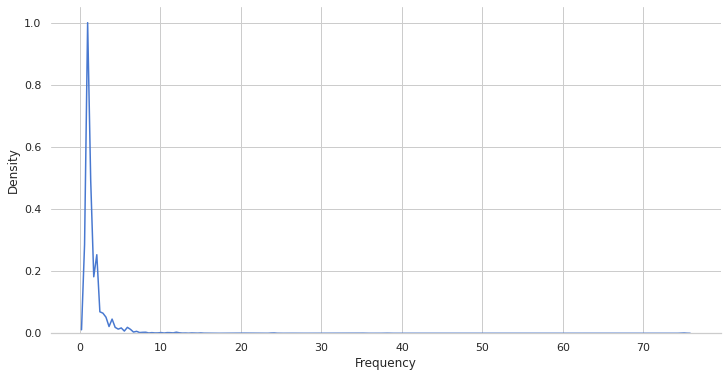

In [33]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

**Frequency Cluster**

Elbow Method

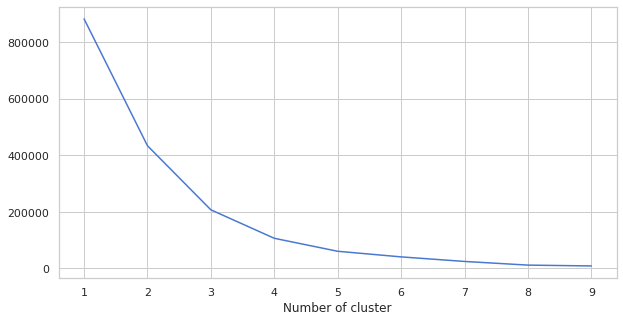

In [34]:
sse={}
df_recency = df_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,99875.0,1.207900,0.405807,1.0,1.0,1.0,1.0,2.0
1,12870.0,4.039005,1.186489,3.0,3.0,4.0,5.0,7.0
2,1464.0,10.831967,2.252463,8.0,9.0,11.0,12.0,16.0
3,397.0,24.536524,6.099081,18.0,20.0,22.0,24.0,38.0
4,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


**Monetary**

*Calculating revenue for each customer*

In [36]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

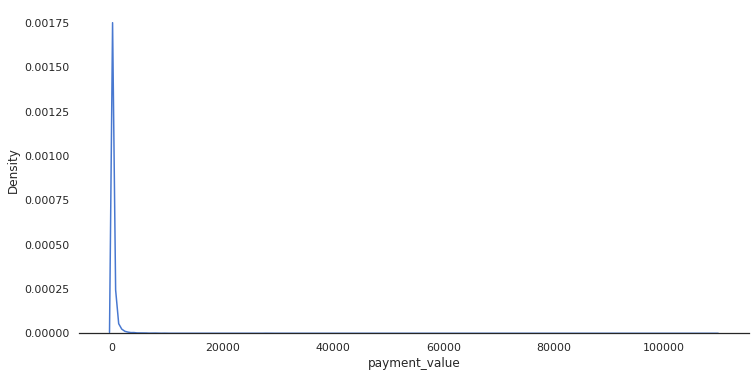

In [37]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

**Monetary cluster**

*Elbow Method*

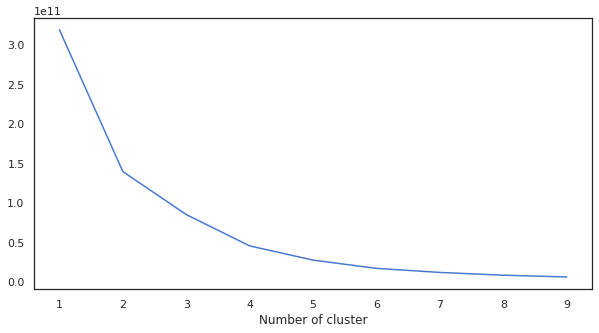

In [38]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [39]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,108364.0,194.082194,194.294684,9.59,67.5900,124.44,234.46,1059.93
1,5366.0,1924.926368,835.210242,1060.80,1286.4025,1639.66,2258.40,4513.32
2,713.0,7106.523829,2117.325473,4534.56,5355.6000,6512.28,8108.64,12490.88
3,184.0,20278.110435,5207.417793,14196.28,16313.6000,19174.38,25051.89,30186.00
4,46.0,43587.292174,2837.177072,36489.24,44048.0000,44048.00,45256.00,45256.00
5,8.0,109312.640000,0.000000,109312.64,109312.6400,109312.64,109312.64,109312.64


In [40]:
df_user

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,payment_value,RevenueCluster
0,708ab75d2a007f0564aedd11139c7708,125,3,1,0,99.33,0
1,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0
2,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0
3,0ae522661311f598df20272643d39ce6,160,3,1,0,157.45,0
4,d386a136dc889cf681443061874caad8,113,3,1,0,136.71,0
...,...,...,...,...,...,...,...
114676,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5
114677,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5
114678,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5
114679,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5


## **Segmenting using the over all score**

In [41]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,502.967092,1.207968,166.830748
1,385.324563,1.378480,199.715257
2,272.442531,1.467455,222.384018
3,169.053264,1.586322,256.940570
4,69.228495,1.693655,305.932804
5,103.436646,6.015805,1223.685095
6,91.547833,6.757848,3099.777668
7,115.689977,12.109557,6057.909184
8,154.866667,12.030303,23948.324485


In [42]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

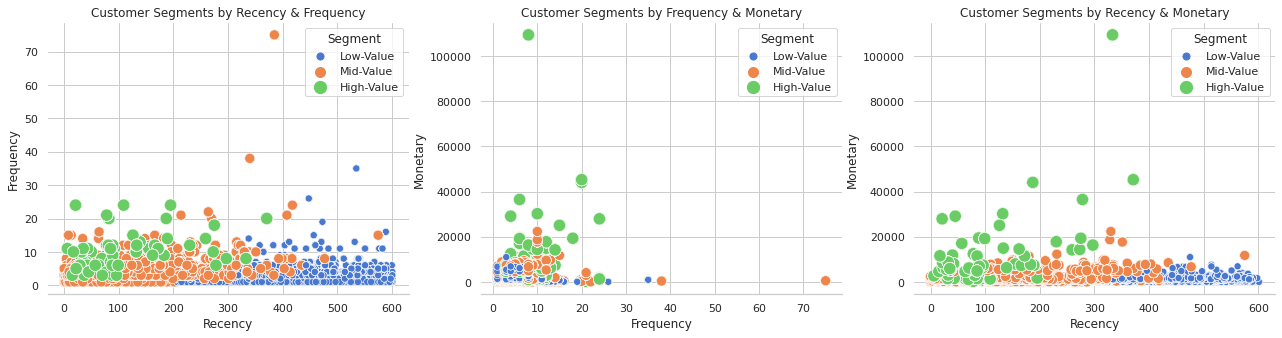

In [43]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

In [44]:
df_user

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,708ab75d2a007f0564aedd11139c7708,125,3,1,0,99.33,0,3,Low-Value
1,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
2,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
3,0ae522661311f598df20272643d39ce6,160,3,1,0,157.45,0,3,Low-Value
4,d386a136dc889cf681443061874caad8,113,3,1,0,136.71,0,3,Low-Value
...,...,...,...,...,...,...,...,...,...
114676,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114677,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114678,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114679,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value


## **K-means on objective functions**

Considering objective funtions cluster as input to further segment the data and obtain the group of customer who are at risk of churn

In [45]:
features_used = df_user[['RecencyCluster', 'FrequencyCluster', 'RevenueCluster']]

In [46]:
df_user

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,708ab75d2a007f0564aedd11139c7708,125,3,1,0,99.33,0,3,Low-Value
1,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
2,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
3,0ae522661311f598df20272643d39ce6,160,3,1,0,157.45,0,3,Low-Value
4,d386a136dc889cf681443061874caad8,113,3,1,0,136.71,0,3,Low-Value
...,...,...,...,...,...,...,...,...,...
114676,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114677,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114678,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value
114679,0a0a92112bd4c708ca5fde585afaa872,333,1,8,2,109312.64,5,8,High-Value


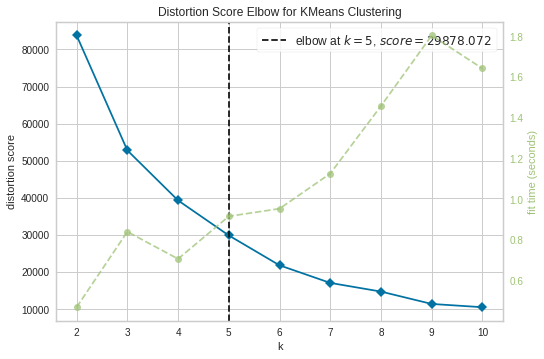

In [47]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,11))
 
visualizer.fit(features_used)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [48]:
#apply clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(features_used)
df_user['clusters_final'] = kmeans.predict(features_used)


#order the cluster numbers
df_user = order_cluster('clusters_final', 'Monetary',df_user,True)

#show details of the dataframe
df_user.groupby('clusters_final')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_final,,,,,,,,
0,28297.0,211.337512,259.489986,13.36,68.190,128.46,242.4400,4483.28
1,25986.0,211.510064,258.821948,11.63,67.500,125.42,247.8300,4408.08
2,23256.0,217.655486,295.783552,9.59,68.545,128.89,243.9175,8891.00
3,32570.0,276.340459,559.235867,10.07,69.100,126.43,254.3450,11745.00
4,4572.0,3827.558040,7337.669480,33.94,1227.000,1804.25,3508.0900,109312.64


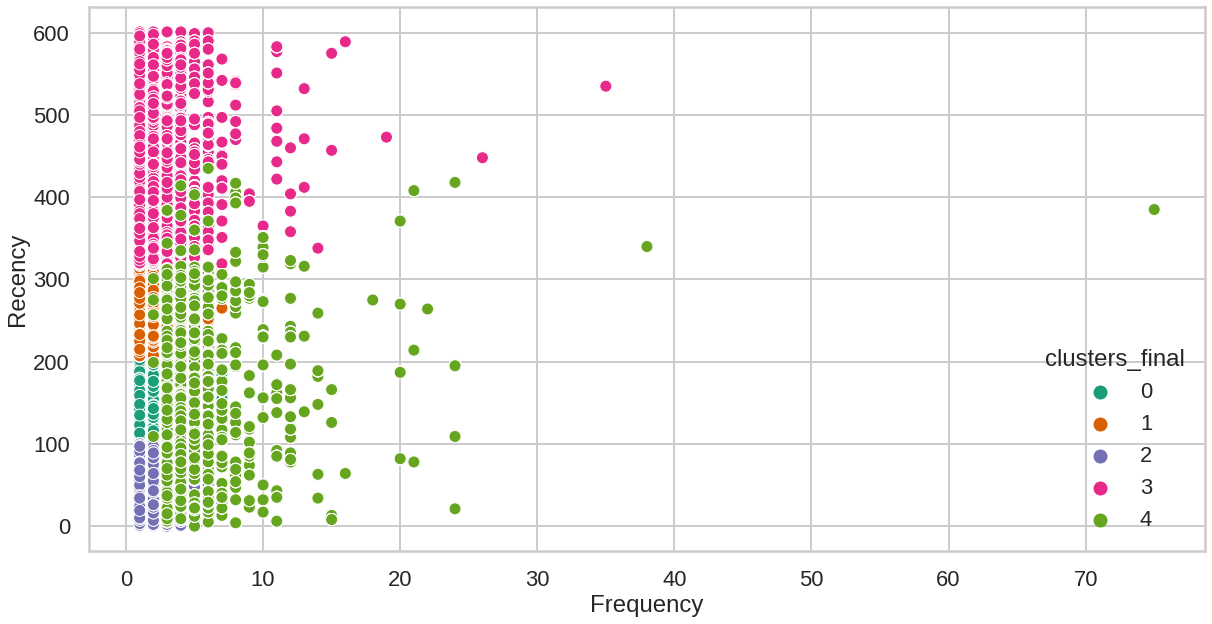

In [52]:
sns.set_context('poster')
plt.figure(figsize=(20,10))
sns.scatterplot(x=df_user['Frequency'],y=df_user['Recency'],hue=df_user['clusters_final'], palette='Dark2')
format_spines(ax, right_border=False)
plt.show()

**Interpretation:**

* **Cluster 0** : Valuable Customers
  * Give promo for events such as blackfriday or Big day sale. This can have discount on products that they usually buy.
  * Give voucher if they high value products. This voucher should be used to buy other products.


* **Cluster 1** : Customers at risk of churn
  * Adding a customers point that can be traded for voucher. This will help customer retain and make more purchase in order to use the voucher.
  * Adding events that provides points to the customers, so that they often visit the website.

* **Cluster 2** : New Customers
  * Give awareness of all the products. This can make customers buy from other product categories.
  * Give discounts based on payment methods. This will help to increase buying frequency.

* **Cluster 3** : Lost Customers
  * Find the reason for discontinue by product and review analysis

* **Cluster 4** : Loyal Customers
  * Give reward for customers. The reward is to give discount on high value products.
  * Give promo for events such as blackfriday or Big day sale. This can have discount on products that they usually buy